## <b> <font color='grey'>AAPL</font> Stock Prices Forecasting </b>
#### <font color='Red'>By</font>  : I Putu Kevin Ari Narayana

#### This project shows AAPL Stock Prices Forecasting using ARIMA (Autoregressive integrated moving average) Model

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## <font color='yellow'><b> DATA UNDERSTANDING </b></font>
##### This data was provided by : finance.yahoo.com

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df=pd.read_csv('C:/Users/HP/Documents/RuangGuru/Python_training/AAPL.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-13,35.477501,35.595001,35.262501,35.262501,33.293438,71291600
2017-04-17,35.369999,35.470001,35.217499,35.457500,33.477551,66328400
2017-04-18,35.352501,35.509998,35.277500,35.299999,33.328842,58790000
2017-04-19,35.470001,35.500000,35.112499,35.169998,33.206097,69313600
2017-04-20,35.305000,35.730000,35.290001,35.610001,33.621532,93278400


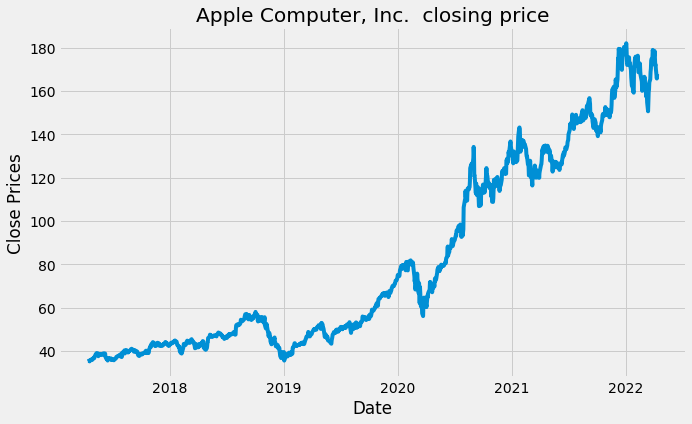

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('Apple Computer, Inc.  closing price')
plt.show()

In [4]:
def data_inv(df):
    print ('Number of rows : ',df.shape[0])
    print('dataset variables: ',df.shape[1])
    print('-'*10)
    print('dataset columns: \n')
    print(df.columns)
    print('-'*10)
    print('data-types each columns: \n')
    print(df.dtypes)
    print('-'*10)
    print('missing row in each columns: \n')
    c=df.isnull().sum()
    print(c[c>0])
data_inv(df)

Number of rows :  1259
dataset variables:  6
----------
dataset columns: 

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
----------
data-types each columns: 

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
----------
missing row in each columns: 

Series([], dtype: int64)


<AxesSubplot:ylabel='Density'>

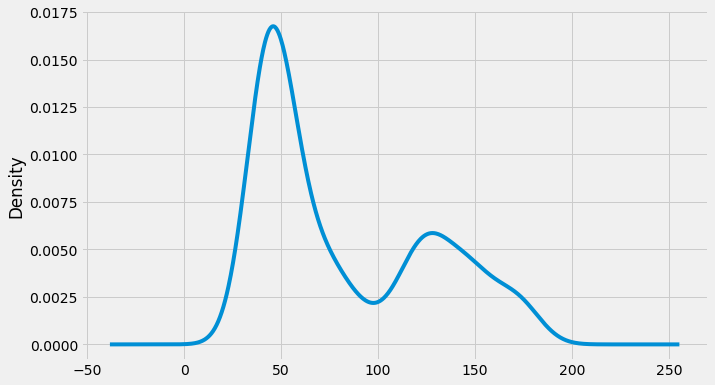

In [6]:
df_close=df['Close']
df_close.plot(kind='kde')

### ADF (Augmented Dickey-Fuller) Test

#### <font color='Green'>H0</font> = The series has a unit root (value of a =1)
#### <font color='Red'>H1</font> =  The series has no unit root.

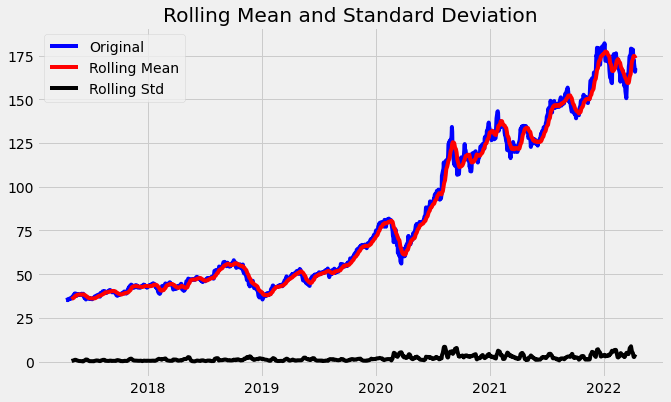

Results of dickey fuller test
Test Statistics                   0.429503
p-value                           0.982565
No. of lags used                 20.000000
Number of observations used    1238.000000
critical value (1%)              -3.435643
critical value (5%)              -2.863877
critical value (10%)             -2.568014
dtype: float64


In [7]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)


##### We see that the p-value is greater than <font color='Yellow'>0.05</font> so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is <font color='Red'>Non-Stationary</font>

### Decomposing the series

<Figure size 720x432 with 0 Axes>

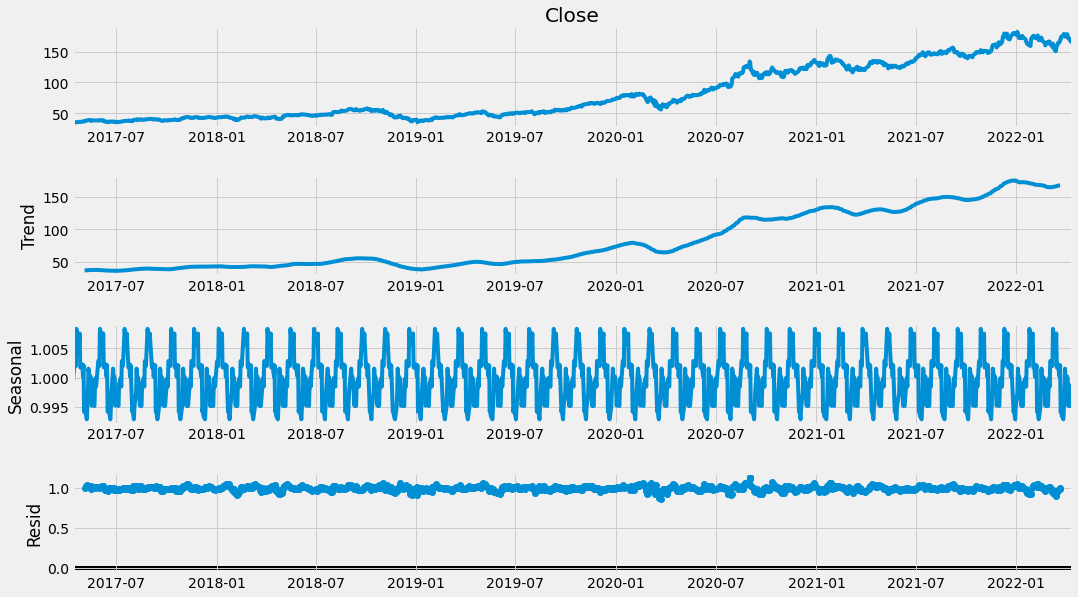

In [8]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

##### We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

### Finding the Moving Average

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(close=None, block=None)>

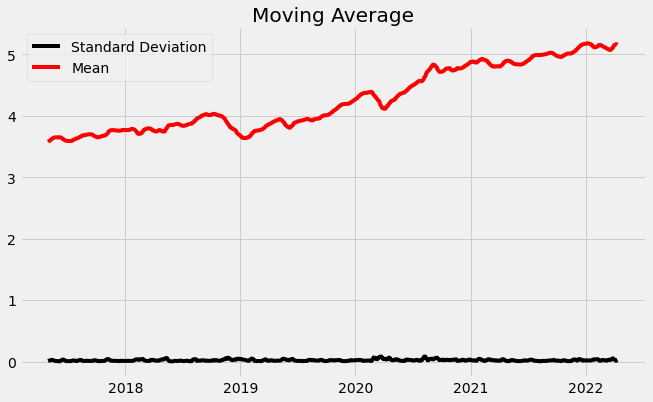

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show

## <font color='Yellow'><b> DATA PREPARATION </b></font>

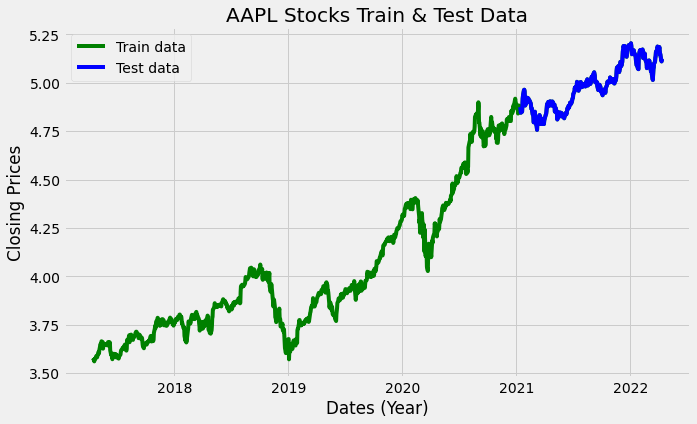

In [10]:
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_log)*0.75):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('AAPL Stocks Train & Test Data')
plt.xlabel('Dates (Year)')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

## <font color='yellow'><b> DATA MODELLING </b></font>
### Using Auto Arima to automatically find best p,q,d value for Arima Model
### Translate = Memakai auto arima untuk menemukan value p,q,d yang paling tepat guys

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4627.458, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4645.974, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4644.943, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4625.243, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4644.229, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4644.235, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4642.201, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4642.348, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.903 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  941
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2325.987
Date:                Thu, 14 Apr 2022   AIC                          -4645.974
Time:                       

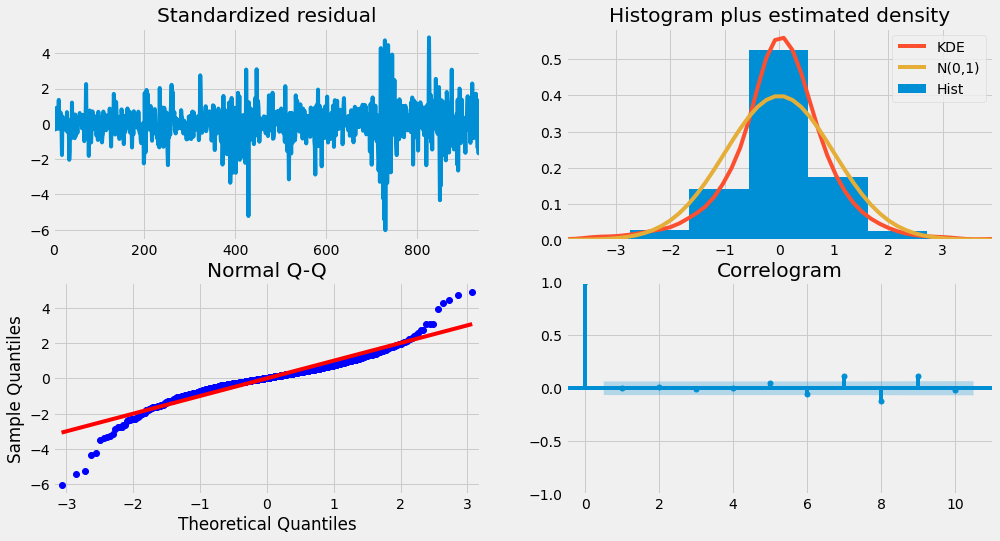

In [32]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

#### From here we know the best p,q,d value to use in prediction model are (2,1,1)
#### Dari sini dapat kita simpulkan bahwa value yang terbaik adalah (2,1,1)

In [33]:
#Creating Data Model for forecasting
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  940
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2325.987
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 14 Apr 2022   AIC                          -4645.975
Time:                        18:21:54   BIC                          -4631.437
Sample:                             1   HQIC                         -4640.433
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      2.381      0.017       0.000       0.003
ar.L1.D.Close    -0.1469      0.032     -4.554      0.000      -0.210      -0.084
                                    Root

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### Setup the Forecast

In [34]:
fc, se, conf = fitted.forecast(315, alpha=0.05)

### Visualizing the Forecast Result :D 
#### After building a good model, lets try use it to forecast 2021 - 2022 APPL Stocks Price

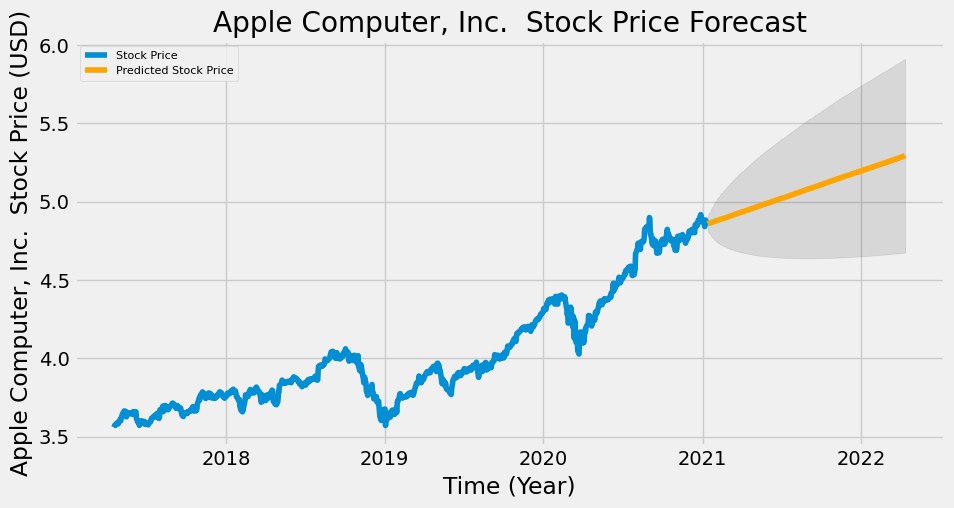

In [35]:
# Make as pandas series # INA = Proses Data menggunakan Pandas
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Stock Price')
# plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Computer, Inc.  Stock Price Forecast')
plt.xlabel('Time (Year)')
plt.ylabel('Apple Computer, Inc.  Stock Price (USD)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

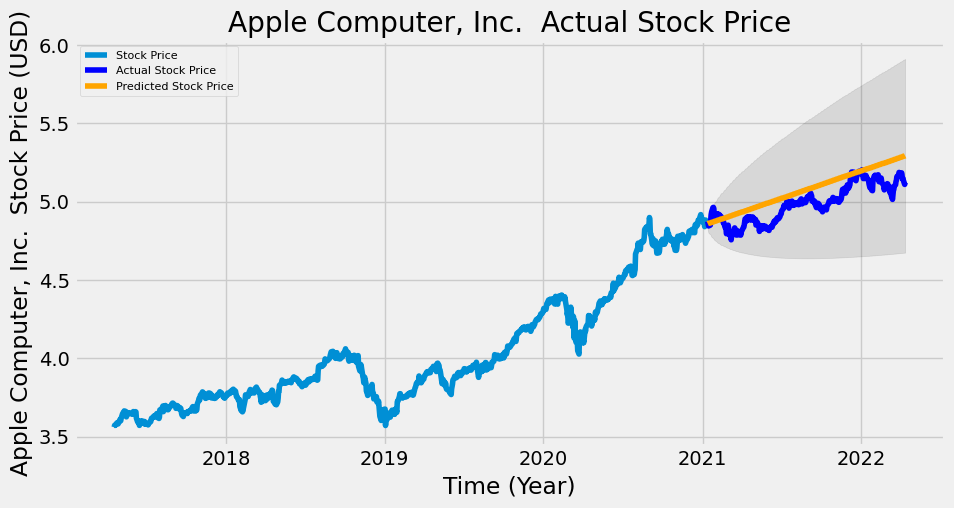

In [36]:
# Make as pandas series # INA = Proses Data menggunakan Pandas
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Stock Price')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Computer, Inc.  Actual Stock Price')
plt.xlabel('Time (Year)')
plt.ylabel('Apple Computer, Inc.  Stock Price (USD)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## DATA EVALUATION
### Let's Test it using commonly used accuracy metrics to judge forecast result
### Yuk di test Yuk

In [37]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.011563068501885229
MAE: 0.0955955304825361
RMSE: 0.10753170928561133
MAPE: 0.019225277714463772


#### Using MAPE as Main metrics, around 1.92% MAPE implies the model is about 98.0% accurate in predicting the next 15 observations.